In [1]:
# Import standard packages
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
# Define parameters
beta = 0.5
gamma = 0.2
infection_cost = 5
constant = 1
chi = 0.7

# Initial values
x0 = np.array([0.99, 0.01])
t_span = (0, 100)
evals = 1000
t_eval = np.linspace(t_span[0], t_span[1], evals+1)

In [3]:
# BASELINE

def ODEsystem(t, y):
    "SIR model ODE system"
    S, I = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    return np.array([dSdt, dIdt])

sol = solve_ivp(fun=ODEsystem, t_span=t_span, y0=x0, t_eval=t_eval)
baseline_S_vals = np.array(sol.y[0])
baseline_I_vals = np.array(sol.y[1])

In [4]:
# UNIVERSAL CONTROL: CENTRAL PLANNER

# Define ODE system
def ODEsystem(t, y, alpha):
    "Modified SIR model ODE system"

    S, I = y
    a1, a2 = alpha
    
    contact_rate = (1 + a1*S*I) ** (-1*a2)
    dSdt = -beta * contact_rate**2 * S * I
    dIdt = beta * contact_rate**2 * S * I - gamma * I
    return np.array([dSdt, dIdt])

def integrand(t, alpha, y):
    "Defines the integrands necessary for the cost function"
    S = np.interp(t, t_eval, y[0])
    I = np.interp(t, t_eval, y[1])
    a1, a2 = alpha
    contact_rate = (1 + a1*S*I) ** (-1*a2)
    integrand_1 = -beta * contact_rate**2 * I
    integrand_2 = constant * (1 - contact_rate)**2
    return integrand_1,integrand_2

def cost_function(alpha):
    "Defines the cost function"
    solution = solve_ivp(fun=ODEsystem, t_span=t_span, y0=x0, t_eval=t_eval, args=(alpha,))
    integrand_1_values = np.array([integrand(t, alpha, solution.y)[0] for t in t_eval])
    integrand_2_values = np.array([integrand(t, alpha, solution.y)[1] for t in t_eval])
    cost = infection_cost * (1 - x0[0] * np.exp(np.trapz(integrand_1_values, t_eval))) + np.trapz(integrand_2_values, t_eval)
    return cost

initial_guess = [infection_cost * beta / constant, 1]

result = minimize(cost_function, initial_guess ,method='BFGS')
alpha = result.x

# Plotting
sol = solve_ivp(fun=ODEsystem, t_span=t_span, y0=x0, t_eval=t_eval, args=(alpha,))
univ_S_vals = np.array(sol.y[0])
univ_I_vals = np.array(sol.y[1])
contact_rate = (1 + alpha[0] * univ_S_vals * univ_I_vals) ** (-1*alpha[1])

In [5]:
# UNIVERSAL CONTROL: INDIVIDUAL

def ODEsystem(t, y, a):
    "Modified SIR model ODE system"

    S, I = y

    a_t = float(np.interp(t, t_eval, a))

    dSdt = -beta * a_t**2 * S * I
    dIdt = beta * a_t**2 * S * I - gamma * I
    return np.array([dSdt, dIdt])

a = np.empty(1001)
a.fill(0.5)
omega = 0.5

for i in range(1000):
    sol = solve_ivp(fun=ODEsystem, t_span=t_span, y0=x0, t_eval=t_eval, args=(a,))
    a = (1 - omega) * a + omega * ((2 * constant) /(2 * constant + infection_cost*beta*sol.y[1]*sol.y[0][-1]))

# Plotting
sol = solve_ivp(fun=ODEsystem, t_span=t_span, y0=x0, t_eval=t_eval, args=(a,))
univ_S_vals_i = np.array(sol.y[0])
univ_I_vals_i = np.array(sol.y[1])

cost = infection_cost * (1- sol.y[0][-1]) + constant * np.trapz((1-a)**2, t_eval)

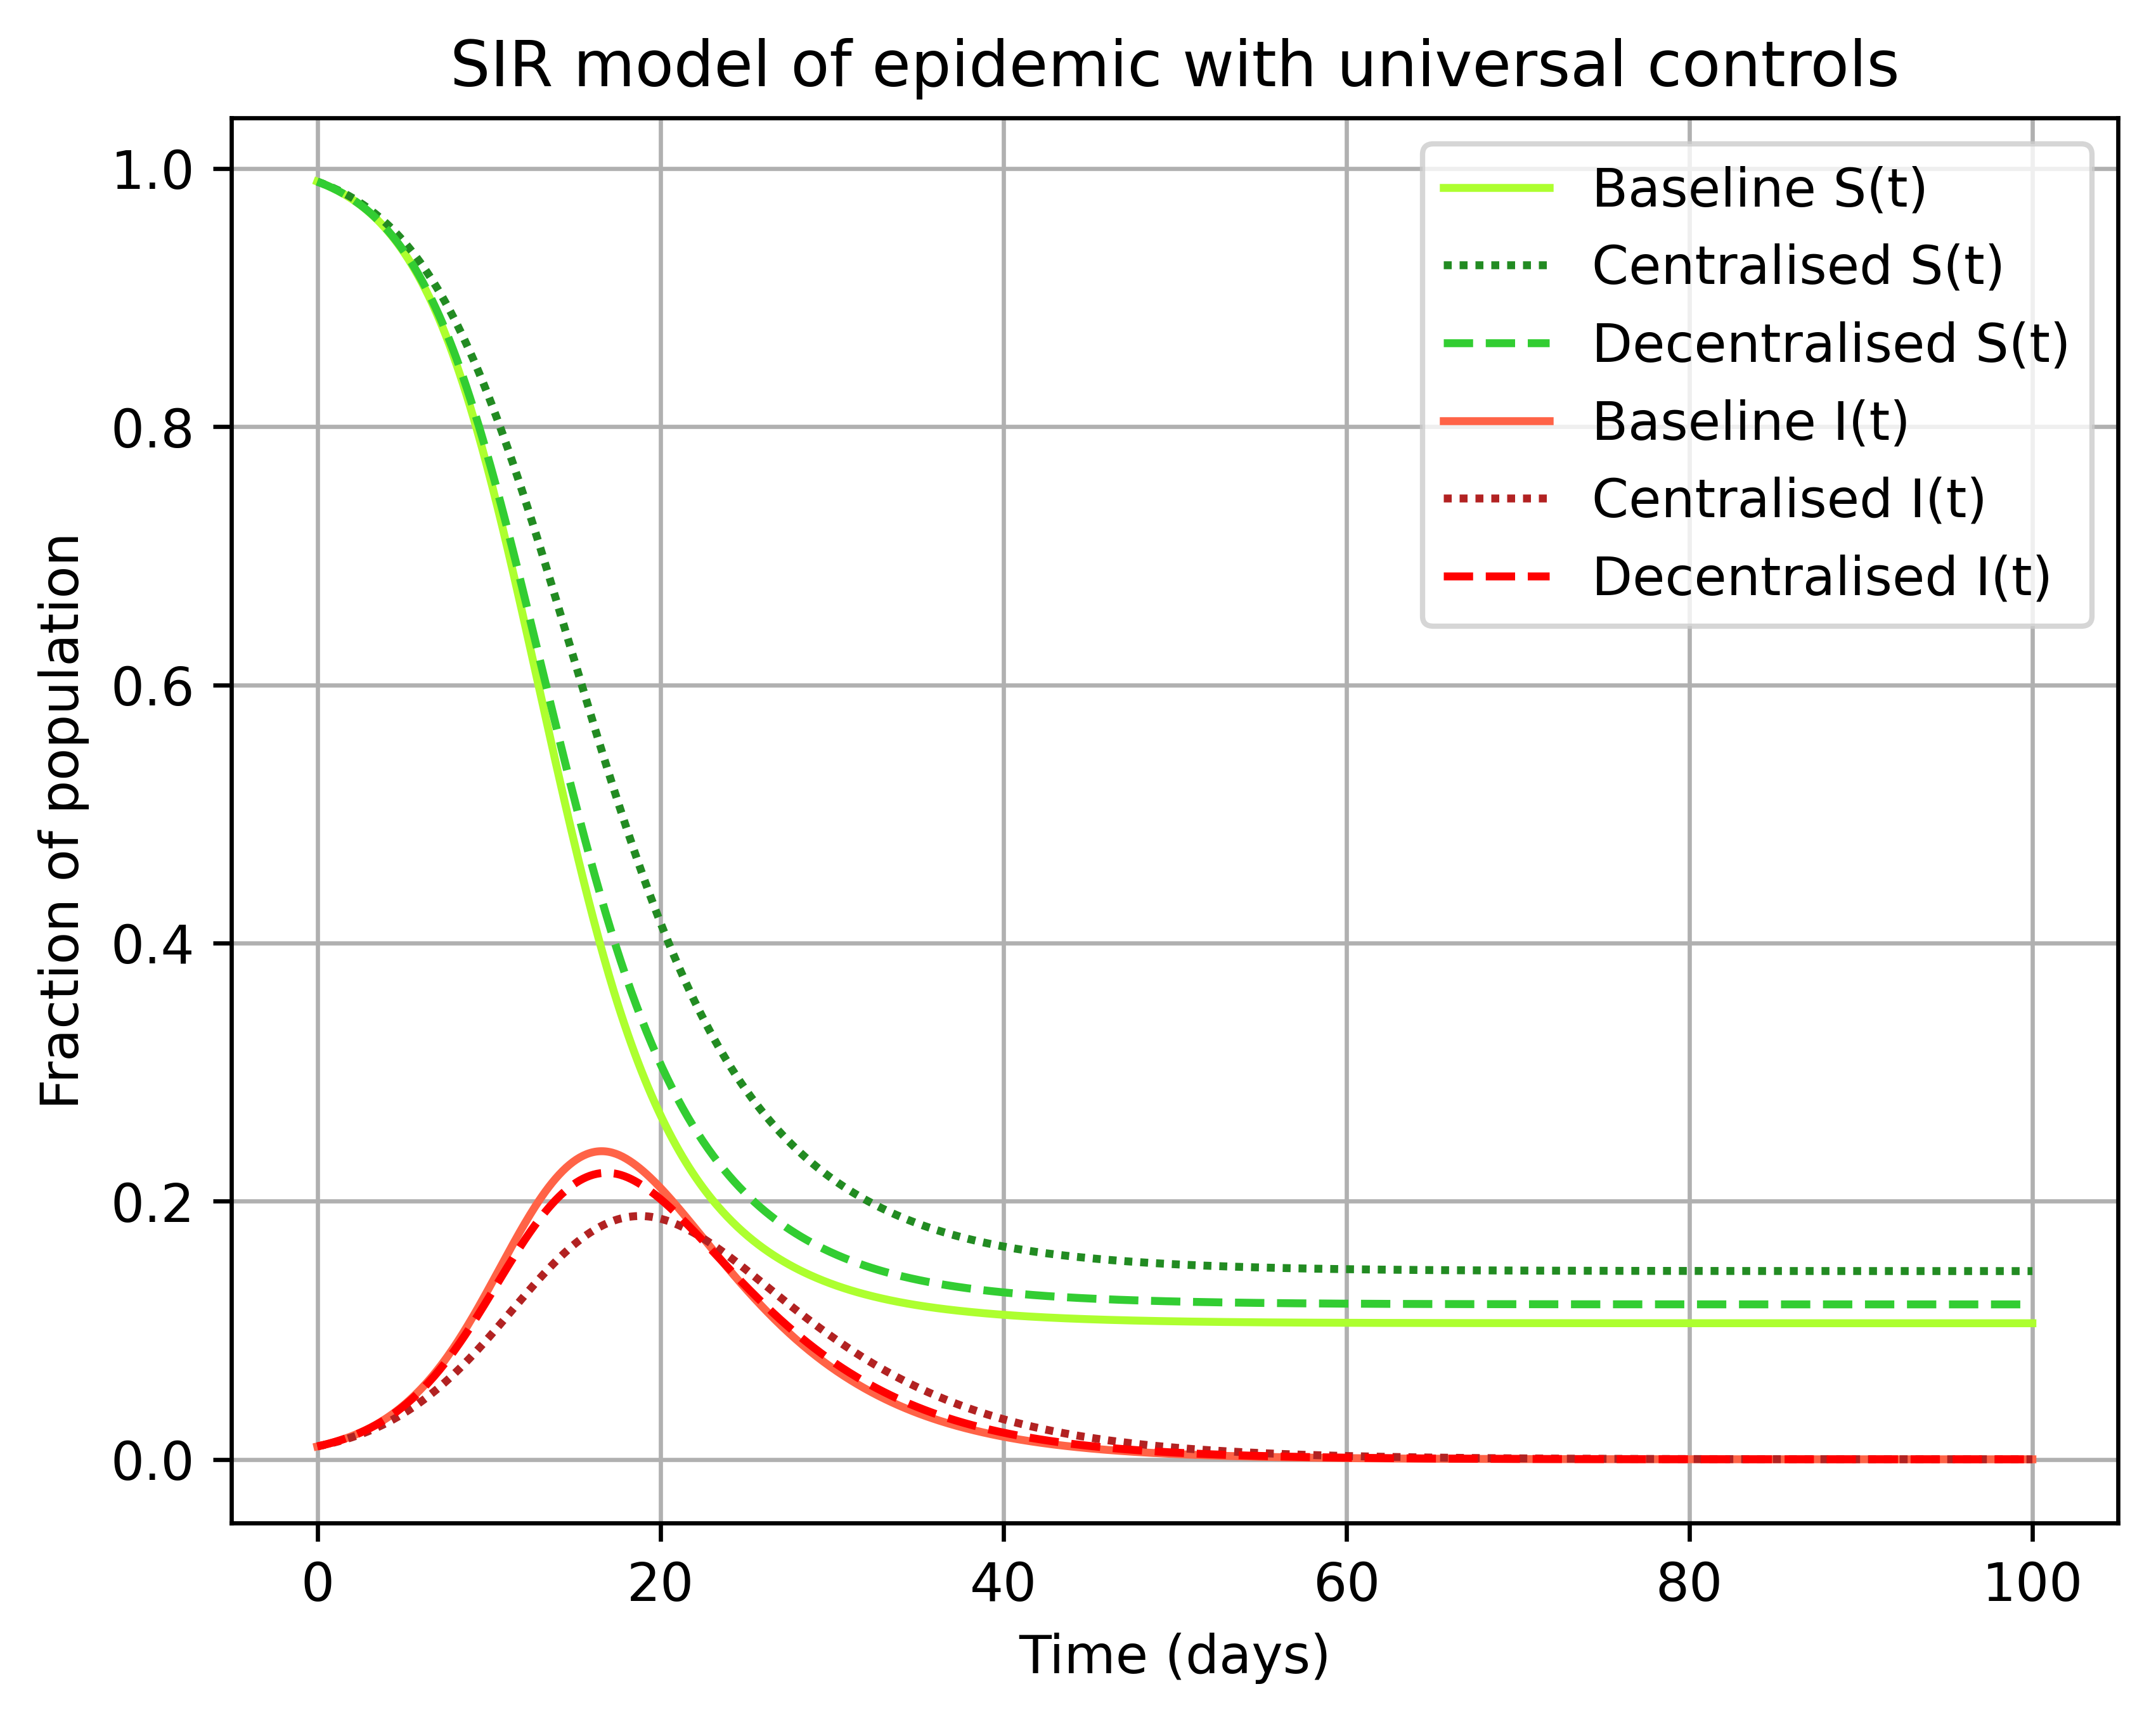

In [6]:
# PLOTTING: UNVIERSAL

# Plot time series

plt.figure(1, dpi=600)

plt.plot(t_eval, baseline_S_vals, color='greenyellow', label='Baseline S(t)')
plt.plot(t_eval, univ_S_vals, color='forestgreen',linestyle=(0, (1, 1)), label='Centralised S(t)')
plt.plot(t_eval, univ_S_vals_i, color='limegreen',linestyle='dashed', label='Decentralised S(t)')

plt.plot(t_eval, baseline_I_vals, color='tomato', label='Baseline I(t)')
plt.plot(t_eval, univ_I_vals, color='firebrick',linestyle=(0, (1, 1)), label='Centralised I(t)')
plt.plot(t_eval, univ_I_vals_i, color='red', linestyle='dashed', label='Decentralised I(t)')

plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Fraction of population')
plt.title("SIR model of epidemic with universal controls")
plt.grid(True)
plt.show()

In [7]:
# COMPARTMENTAL CONTROL: CENTRAL PLANNER

# ODE System

def ODEsystem(t, y, alpha):
    S, I = y

    aS1, aS2, aI1, aI2 = alpha
    
    contact_rate_S = (1 - aS1 * I) / (1 - aS1 * aS2 * S * I)
    contact_rate_I = (1 - aI1 * S) / (1 - aI1 * aI2 * S * I)

    contact_rate_I = np.maximum(contact_rate_I, contact_rate_S * chi)

    infection_term = beta * contact_rate_I * contact_rate_S * S * I
    dSdt = -infection_term
    dIdt = infection_term - gamma * I

    return np.array([dSdt, dIdt])

# Integrand for cost

def integrand(t, alpha, y):
    S = np.interp(t, t_eval, y[0])
    I = np.interp(t, t_eval, y[1])

    aS1, aS2, aI1, aI2 = alpha

    contact_rate_S = (1 - aS1 * I) / (1 - aS1 * aS2 * S * I)
    contact_rate_I = (1 - aI1 * S) / (1 - aI1 * aI2 * S * I)

    contact_rate_I = np.maximum(contact_rate_I, contact_rate_S * chi)

    integrand_1 = -beta * contact_rate_I * contact_rate_S * I
    integrand_2 = constant * I * (1 - contact_rate_I)**2
    integrand_3 = constant * S * (1 - contact_rate_S)**2

    return integrand_1, integrand_2, integrand_3

# Cost function

def cost_function(alpha):
    solution = solve_ivp(
        fun=ODEsystem,
        t_span=t_span,
        y0=x0,
        t_eval=t_eval,
        args=(alpha,),)

    integrand_1_values = np.array([integrand(t, alpha, solution.y)[0] for t in t_eval])
    integrand_2_values = np.array([integrand(t, alpha, solution.y)[1] for t in t_eval])
    integrand_3_values = np.array([integrand(t, alpha, solution.y)[2] for t in t_eval])

    cost = infection_cost * (1 - x0[0]*np.exp(np.trapz(integrand_1_values, t_eval)))
    cost += np.trapz(integrand_2_values, t_eval)
    cost += np.trapz(integrand_3_values, t_eval)
    return cost

# Initial guess

aS1_initial = (infection_cost * beta)/ (2 * constant)
aS2_initial = aS1_initial
aI1_initial = aS1_initial
aI2_initial = aS1_initial

initial_guess = [aS1_initial, aS2_initial, aI1_initial, aI2_initial]

bounds = [(None, None), (0, 1), (None, None), (0, 1),]

result = minimize(cost_function, initial_guess, method="L-BFGS-B", bounds=bounds)
alpha = result.x
print("Optimized α:", alpha)
print(result.fun)

# Plotting 
sol = solve_ivp(fun=ODEsystem, t_span=t_span, y0=x0, t_eval=t_eval, args=(alpha,))
comp_S_vals = np.array(sol.y[0])
comp_I_vals = np.array(sol.y[1])
comp_contact_rate_S = np.array([((1 - alpha[0] * comp_I_vals[i]) / (1 - alpha[0] * alpha[1] * comp_S_vals[i] * comp_I_vals[i])) for i in range(len(t_eval))])
comp_contact_rate_I = np.array([((1 - alpha[2] * comp_S_vals[i]) / (1 - alpha[2] * alpha[3] * comp_S_vals[i] * comp_I_vals[i])) for i in range(len(t_eval))])
comp_contact_rate_I = np.array([max(comp_contact_rate_I[i], comp_contact_rate_S[i] * chi) for i in range(len(t_eval))])

Optimized α: [5.31245237 0.93510306 1.25       1.        ]
3.5220826596112156


In [8]:
# COMPARTMENTAL CONTROL: INDIVIDUAL

def ODEsystem(t, y, a):

    S, I = y

    a_t = float(np.interp(t, t_eval, a))

    dSdt = -beta * a_t * S * I
    dIdt = beta * a_t * S * I - gamma * I
    return np.array([dSdt, dIdt])


def Nash_condition(a):

    sol = solve_ivp(fun=ODEsystem, t_span=t_span, y0=x0, args=(a,), t_eval=t_eval,)
    S,I = sol.y

    total_susceptibles = x0[0] * np.exp(np.trapz(-beta * a**2 * I, sol.t))
    total_susceptibles = S[-1]

    # Simplified
    simple_a = 1 - infection_cost * beta * I * total_susceptibles / (2*constant*S)

    # Correction
    complex_a = np.full_like(simple_a, 0)
    complex_a[-1] = simple_a[-1] 

    for i in range(evals-1,-1,-1): # Starting at one tick before the final eval, iterate backwards.
        complex_a[i] = simple_a[i] + (beta*I[i]/(2*S[i])) * np.trapz(S[i+1:] * (1-complex_a[i+1:])**2, t_eval[i+1:])

    return (1-omega)*a + omega * complex_a

a_S = np.empty(1001)
a_S.fill(0.5)
omega = 0.5

for i in range(1000):
    a_S = Nash_condition(a_S)

# Plotting
sol = solve_ivp(fun=ODEsystem, t_span=t_span, y0=x0, t_eval=t_eval, args=(a_S,))
comp_S_vals_i = np.array(sol.y[0])
comp_I_vals_i = np.array(sol.y[1])

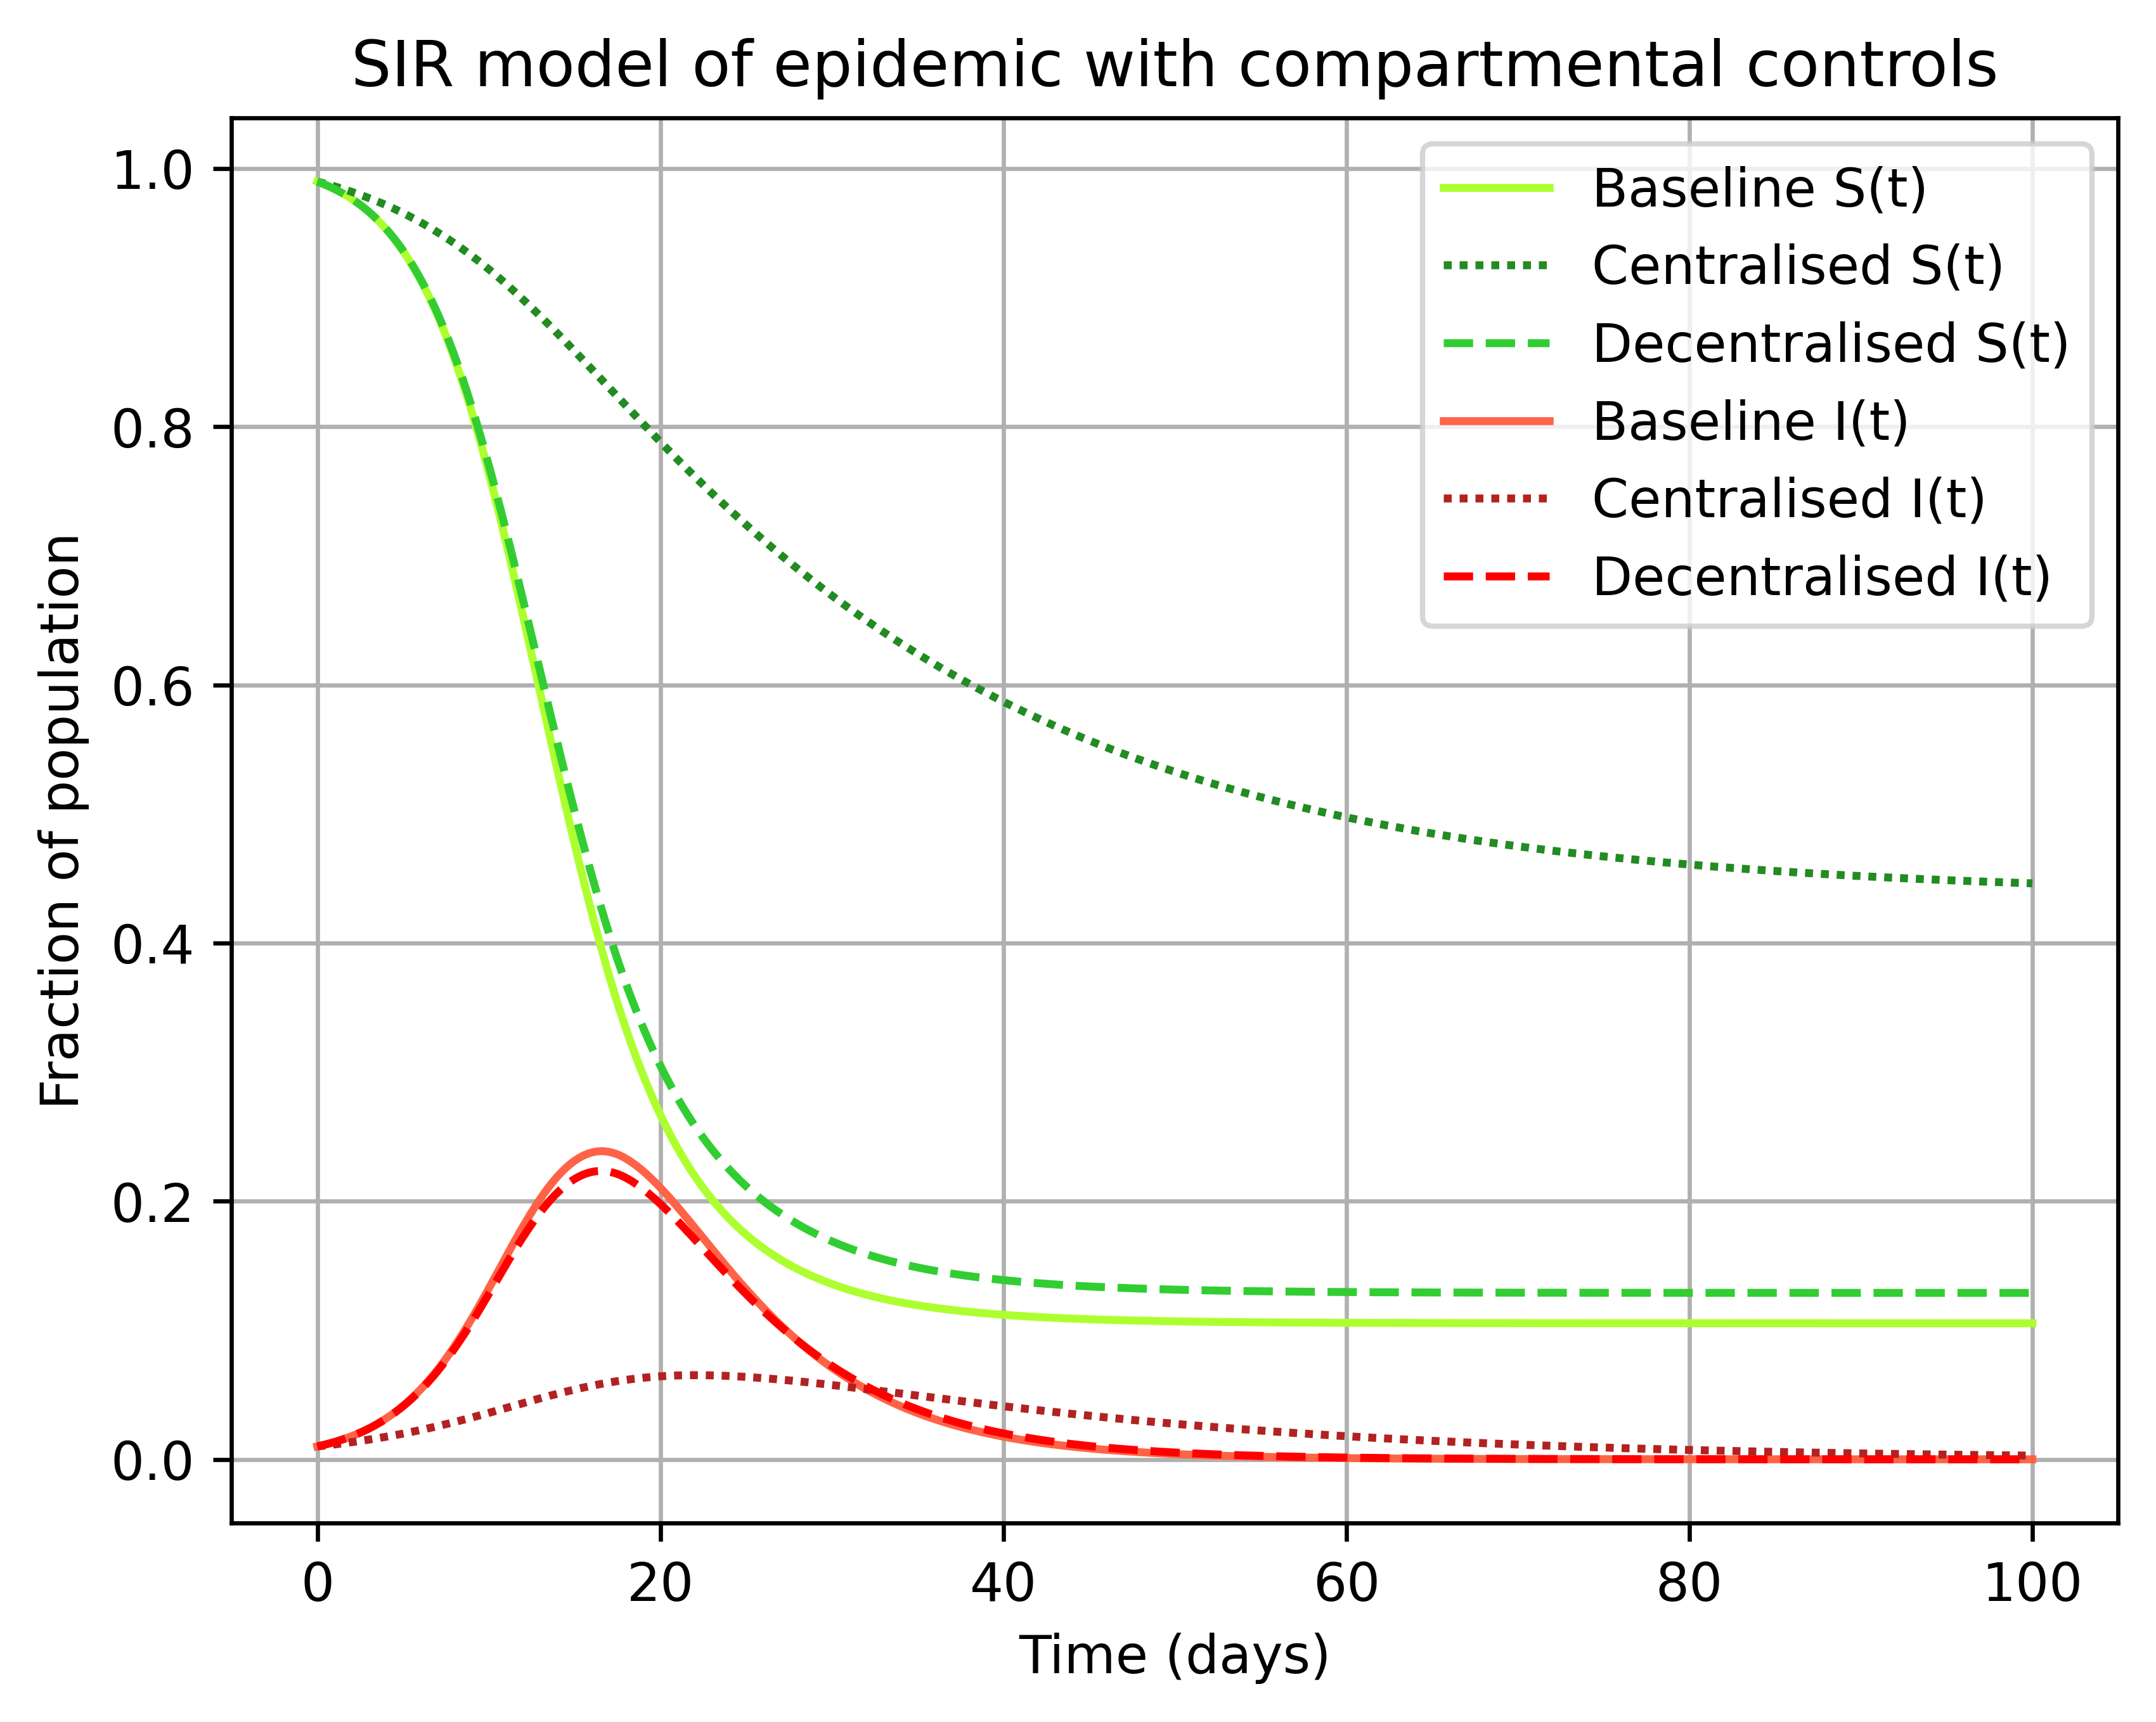

In [9]:
# PLOTTING: COMPARTMENTAL

# Plot time series

plt.figure(1, dpi=600)

plt.plot(t_eval, baseline_S_vals, color='greenyellow', label='Baseline S(t)')
plt.plot(t_eval, comp_S_vals, color='forestgreen',linestyle=(0, (1, 1)), label='Centralised S(t)')
plt.plot(t_eval, comp_S_vals_i, color='limegreen',linestyle='dashed', label='Decentralised S(t)')

plt.plot(t_eval, baseline_I_vals, color='tomato', label='Baseline I(t)')
plt.plot(t_eval, comp_I_vals, color='firebrick',linestyle=(0, (1, 1)), label='Centralised I(t)')
plt.plot(t_eval, comp_I_vals_i, color='red', linestyle='dashed', label='Decentralised I(t)')

plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Fraction of population')
plt.title("SIR model of epidemic with compartmental controls")
plt.grid(True)
plt.show()

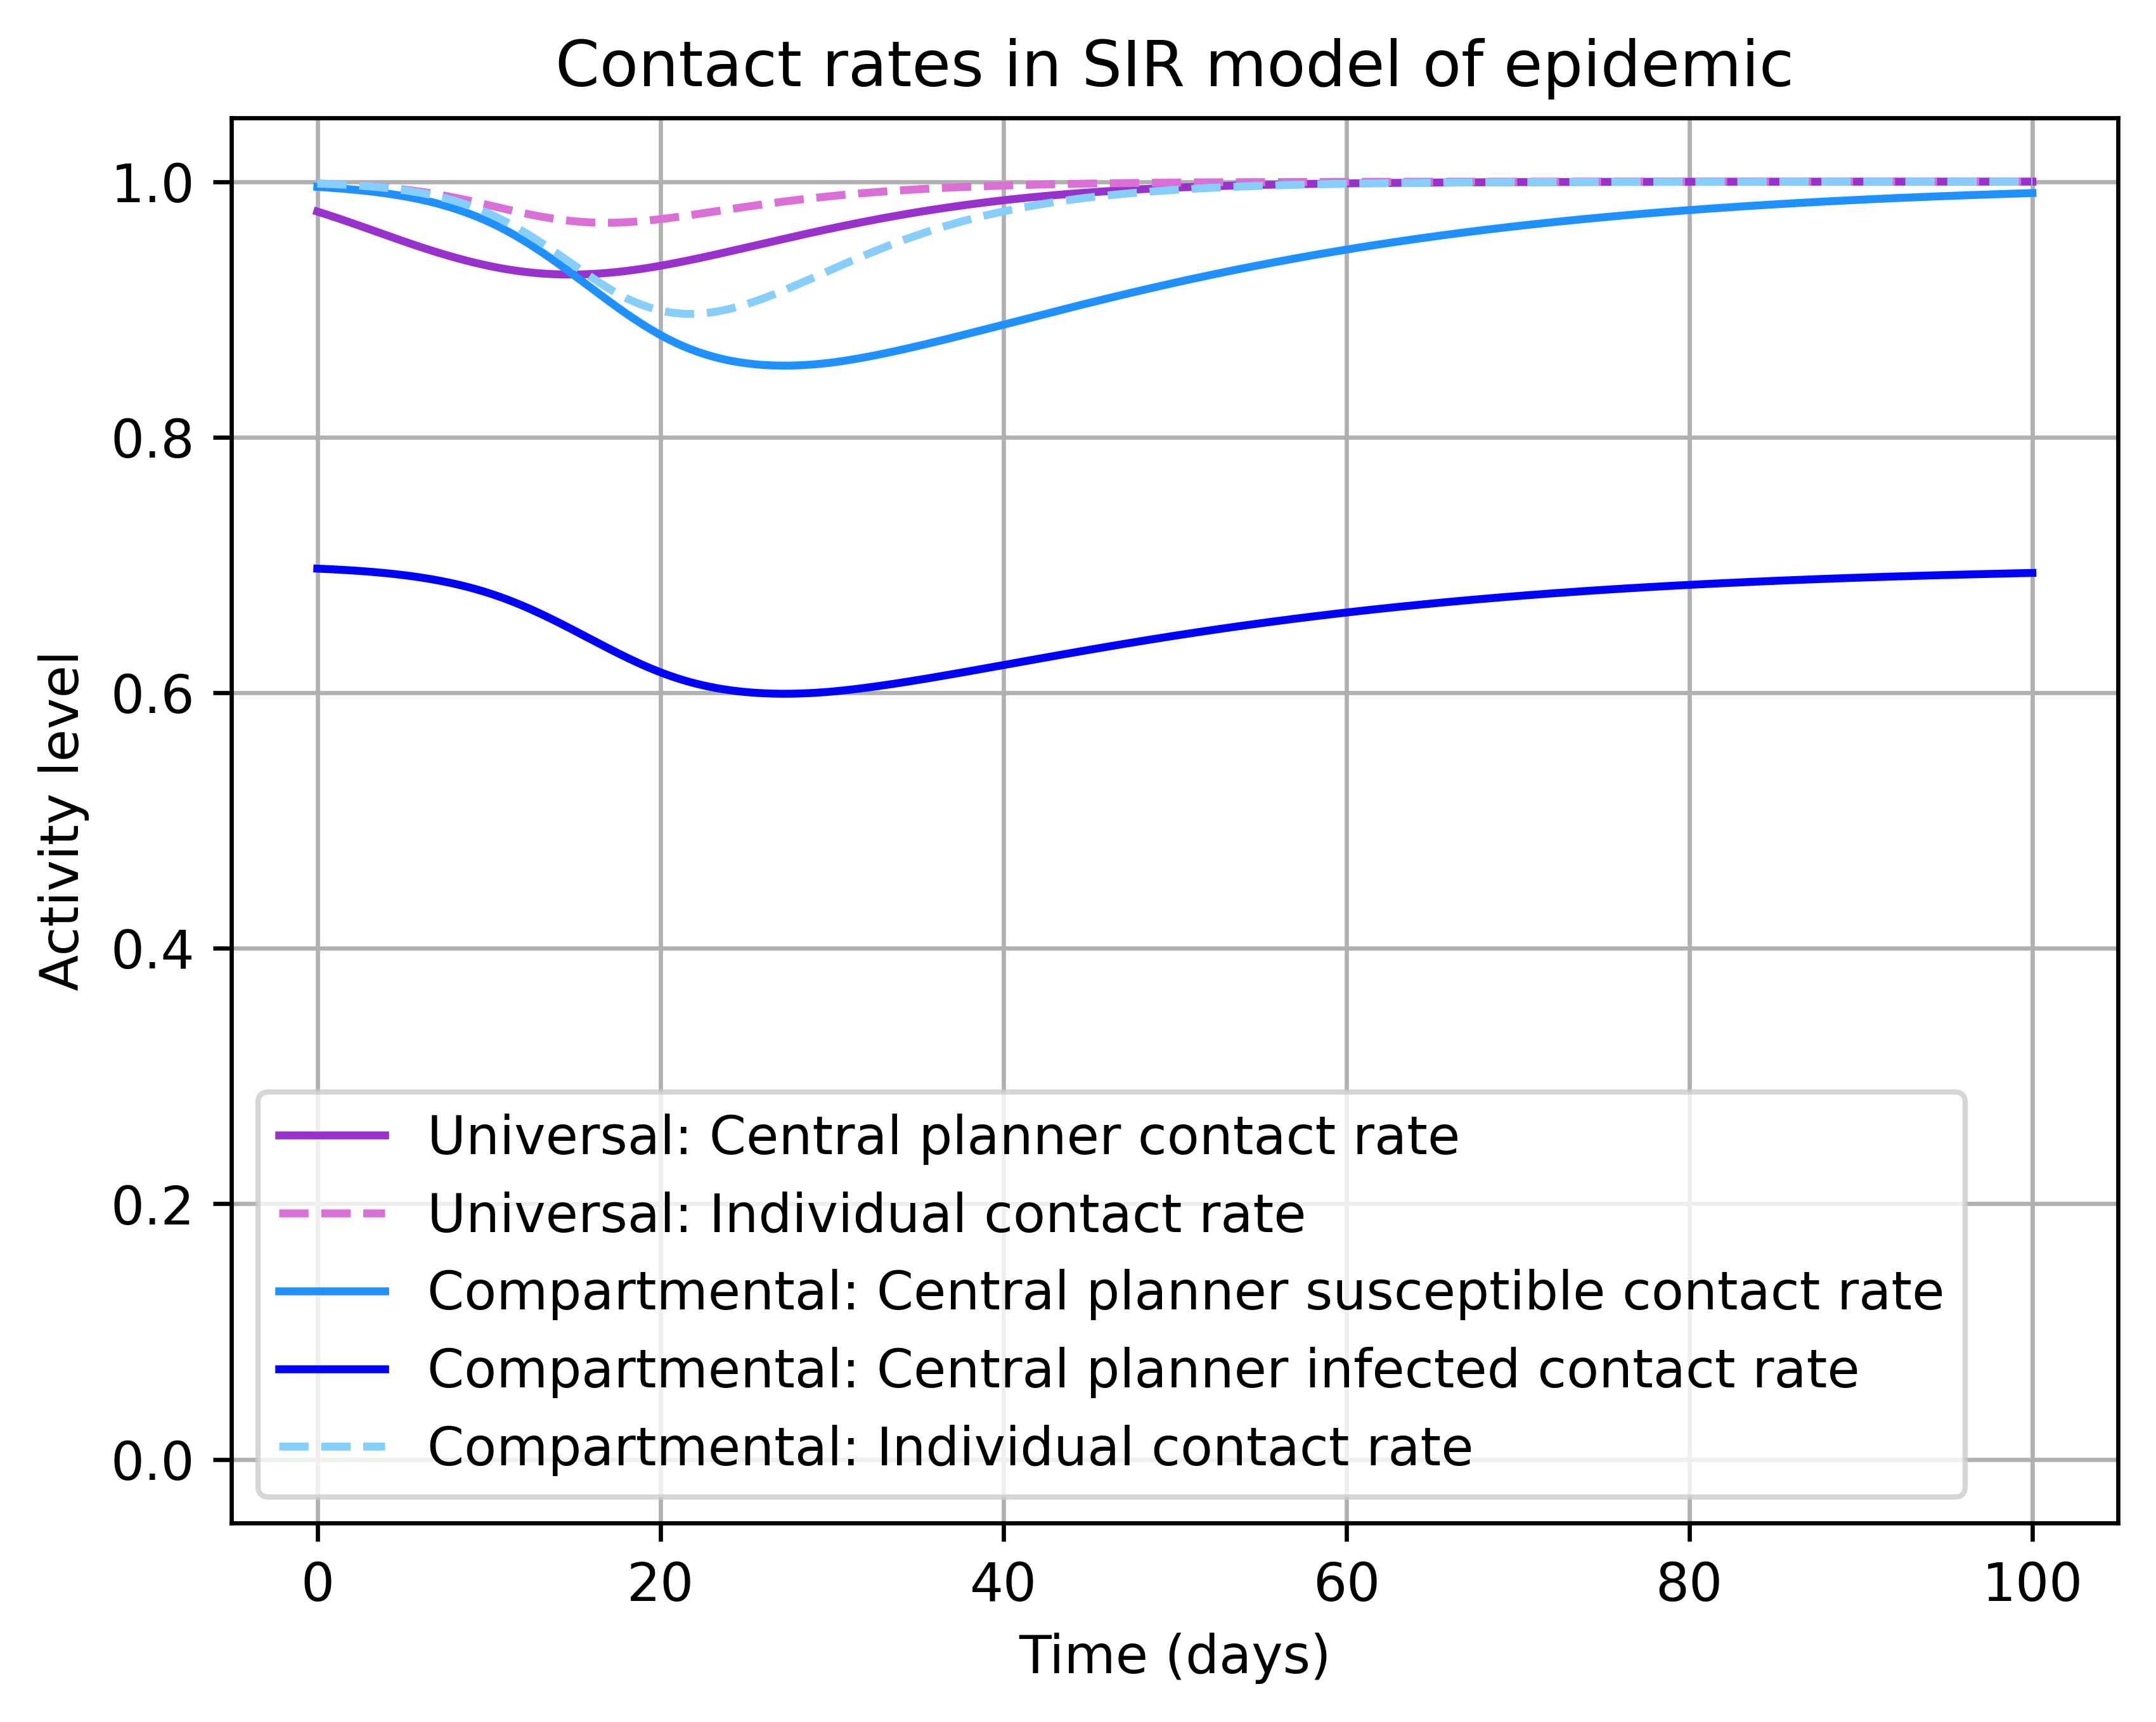

In [10]:
# Plotting: Contact rates

plt.figure(1, dpi=600)

plt.plot(t_eval, contact_rate, color='darkorchid', label="Universal: Central planner contact rate")
plt.plot(t_eval, a, color='orchid', linestyle='dashed', label="Universal: Individual contact rate")
plt.plot(t_eval, comp_contact_rate_S, color='dodgerblue', label='Compartmental: Central planner susceptible contact rate')
plt.plot(t_eval, comp_contact_rate_I, color='blue', label='Compartmental: Central planner infected contact rate')
plt.plot(t_eval, a_S, color='lightskyblue', linestyle='dashed', label="Compartmental: Individual contact rate")

plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Activity level')
plt.ylim(-0.05, 1.05)
plt.title("Contact rates in SIR model of epidemic")
plt.grid(True)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=31c9b690-0312-49be-b253-a02ef8875e12' target="_blank">

Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>